# **1. Project Overview**

This notebook builds and evaluates **ensemble classification models** — Random Forest, Gradient Boosting, and a Neural Network (MLP) — on an engineered financial dataset (`multi_ticker_earnings_dataset.csv`).
We aim to:

* Identify the most influential predictive features,
* Tune each model for optimal performance,
* Compare model robustness via ROC-AUC and classification metrics.

## **2. Methodology Outline**

1. Data loading and exploratory analysis
2. Feature-target split and scaling
3. Recursive feature elimination with cross-validation (RFECV)
4. Model training — Random Forest, Gradient Boosting, and MLP
5. Evaluation with confusion matrix and ROC analysis

In [16]:
# Cell 1 — Imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.inspection import permutation_importance

from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## **3. Data Loading and Preliminary Exploration**

The dataset is loaded into a pandas DataFrame.
We briefly examine the available columns and calculate **absolute correlation coefficients** of all numeric features with the binary target variable `Target`.

This helps identify which engineered indicators show stronger linear associations before formal feature selection.

---

In [7]:
# Cell 2 — Load Dataset and Inspect Correlations

# ── Load the dataset ─────────────────────────────────────────
df = pd.read_csv("multi_ticker_earnings_dataset.csv")
print(df.columns.tolist())

# Focus on numeric predictors when evaluating correlation with target
numeric_features = df.select_dtypes(include=[np.number]).drop(columns=["Target"], errors="ignore")
corr = numeric_features.corrwith(df["Target"]).abs().sort_values(ascending=False)
print(corr)

['Date', 'Ticker', 'Close', 'Volume', 'Return', 'Volatility', 'RSI', 'MA5', 'MA10', 'MA_ratio', 'Volume_Avg20', 'Volume_Spike', 'Momentum3', 'ATR14', 'DayOfWeek', 'Month', 'Surprise_%', 'CumulativeReturn5', 'CumulativeReturn20', 'MA_CrossGap', 'PositiveDays_5', 'VolatilityChange', 'Skew5', 'HighVol', 'VolatilityJump', 'VolPriceCorr20', 'VolumeDivergence', 'SurpriseDecay5', 'EventShock', 'DaysSinceEarnings', 'MomentumVolRatio', 'EarningsImpactMag', 'Target']
EarningsImpactMag     0.023897
MomentumVolRatio      0.023006
Momentum3             0.021980
DayOfWeek             0.021405
Month                 0.020359
MA10                  0.016515
MA5                   0.016336
Close                 0.016140
RSI                   0.014883
VolPriceCorr20        0.012944
CumulativeReturn5     0.012793
Volatility            0.012333
EventShock            0.011217
VolatilityJump        0.009787
Return                0.009668
PositiveDays_5        0.008831
ATR14                 0.008517
VolumeDiver

C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## **4. Feature Selection Setup**

We exclude non-predictive and identifier columns (`Date`, `Ticker`, etc.) before model training.
The data is split into **training (85%)** and **testing (15%)** subsets using **stratified sampling** to maintain class balance.

Since MLPs are sensitive to feature magnitudes, a **StandardScaler** is applied to ensure zero-mean, unit-variance scaling across features.

---

In [30]:
# Cell 3 — Feature & Target Split + Scaling

# ── Split into features and target ────────────────────────────
X = df.drop(['Date', 'Ticker', 'Target', 'MA_ratio', 'Close', 'Volume'], axis=1)
y = df['Target']

# ── Train-test split (85-15 stratified) ───────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## **5. Recursive Feature Elimination with Cross-Validation (RFECV)**

To identify the most informative features, we apply **RFECV** using:

* Random Forest
* Gradient Boosting
* MLP

Each estimator recursively removes the least important features and evaluates accuracy via 5-fold cross-validation.

Plots visualize accuracy against the number of retained features, helping us find an **optimal feature subset** per model.

---


🔹 Running RFECV for Random Forest...
Optimal number of features for Random Forest: 4


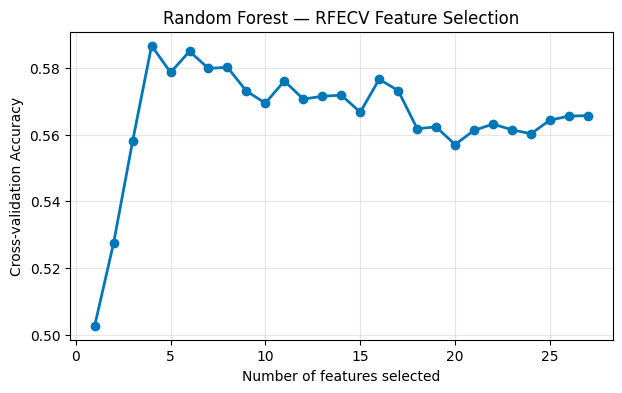

Top 4 features for Random Forest:
['VolatilityChange', 'VolatilityJump', 'SurpriseDecay5', 'MomentumVolRatio']

🔹 Running RFECV for Gradient Boosting...
Optimal number of features for Gradient Boosting: 23


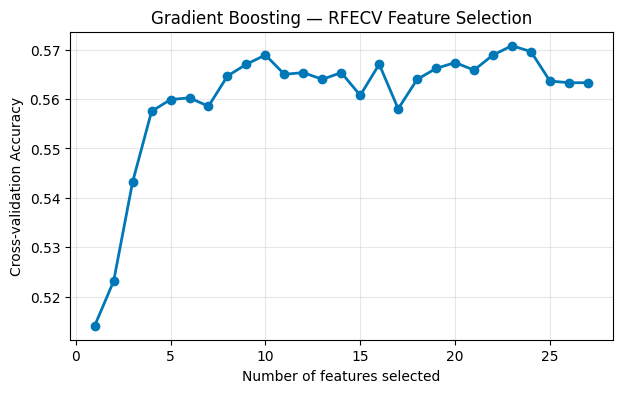

Top 23 features for Gradient Boosting:
['Return', 'Volatility', 'RSI', 'MA5', 'MA10', 'Volume_Avg20', 'Volume_Spike', 'Momentum3', 'ATR14', 'DayOfWeek', 'Month', 'Surprise_%', 'CumulativeReturn5', 'CumulativeReturn20', 'MA_CrossGap', 'VolatilityChange', 'Skew5', 'VolatilityJump', 'VolPriceCorr20', 'VolumeDivergence', 'SurpriseDecay5', 'MomentumVolRatio', 'EarningsImpactMag']

✅ Feature Selection Summary:
Random Forest: 4 features
Gradient Boosting: 23 features


In [28]:
# --- Helper: Perform RFECV for a model ---

def feature_selection_with_rfecv(model, X, y, name, step=1):
    print(f"\n🔹 Running RFECV for {name}...")
    assert len(X) == len(y), f"Length mismatch: X={len(X)}, y={len(y)}"
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rfecv = RFECV(
        estimator=model,
        step=step,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0
    )
    rfecv.fit(X, y)

    print(f"Optimal number of features for {name}: {rfecv.n_features_}")

    # --- compatibility across sklearn versions ---
    if hasattr(rfecv, "cv_results_"):
        scores = rfecv.cv_results_["mean_test_score"]
    elif hasattr(rfecv, "grid_scores_"):   # legacy fallback
        scores = rfecv.grid_scores_
    else:
        raise AttributeError("RFECV does not have cv_results_ or grid_scores_. Check sklearn version.")

    # --- Plot the cross-validation performance curve ---
    plt.figure(figsize=(7,4))
    plt.title(f"{name} — RFECV Feature Selection")
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation Accuracy")
    plt.plot(range(1, len(scores) + 1), scores, marker="o", linewidth=2, color="#0077b6")
    plt.grid(alpha=0.3)
    plt.show()

    # --- Retrieve top features ---
    selected_features = X.columns[rfecv.support_]
    print(f"Top {len(selected_features)} features for {name}:")
    print(selected_features.to_list())

    return selected_features

# --- Run RFECV for each model ---
rf_features = feature_selection_with_rfecv(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X, y, "Random Forest"
)

gb_features = feature_selection_with_rfecv(
    GradientBoostingClassifier(random_state=42),
    X, y, "Gradient Boosting"
)


print("\n✅ Feature Selection Summary:")
print(f"Random Forest: {len(rf_features)} features")
print(f"Gradient Boosting: {len(gb_features)} features")


In [29]:
def mlp_rfecv_permutation(X, y, step=1, min_features_to_select=3, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    features = list(X.columns)
    history = []

    while len(features) > min_features_to_select:
        scores = []

        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx][features], X.iloc[test_idx][features]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
            model.fit(X_train, y_train)

            base_score = model.score(X_test, y_test)
            perm = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
            scores.append((base_score, perm.importances_mean))

        # average permutation importance over folds
        mean_importance = np.mean([s[1] for s in scores], axis=0)
        avg_score = np.mean([s[0] for s in scores])

        # remove the least important feature(s)
        drop_indices = np.argsort(mean_importance)[:step]
        drop_feats = [features[i] for i in drop_indices]
        features = [f for f in features if f not in drop_feats]

        history.append((len(features), avg_score))
        print(f"Remaining: {len(features):2d} | CV Accuracy: {avg_score:.4f}")

    return features, pd.DataFrame(history, columns=["num_features", "cv_acc"])

X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
mlp_selected, mlp_history = mlp_rfecv_permutation(X_train_df, y_train)

Remaining: 26 | CV Accuracy: 0.5380
Remaining: 25 | CV Accuracy: 0.5443
Remaining: 24 | CV Accuracy: 0.5497
Remaining: 23 | CV Accuracy: 0.5413
Remaining: 22 | CV Accuracy: 0.5527
Remaining: 21 | CV Accuracy: 0.5461
Remaining: 20 | CV Accuracy: 0.5509
Remaining: 19 | CV Accuracy: 0.5491
Remaining: 18 | CV Accuracy: 0.5611
Remaining: 17 | CV Accuracy: 0.5441
Remaining: 16 | CV Accuracy: 0.5519
Remaining: 15 | CV Accuracy: 0.5404
Remaining: 14 | CV Accuracy: 0.5455
Remaining: 13 | CV Accuracy: 0.5567
Remaining: 12 | CV Accuracy: 0.5535
Remaining: 11 | CV Accuracy: 0.5479
Remaining: 10 | CV Accuracy: 0.5547
Remaining:  9 | CV Accuracy: 0.5535
Remaining:  8 | CV Accuracy: 0.5637
Remaining:  7 | CV Accuracy: 0.5667
Remaining:  6 | CV Accuracy: 0.5753
Remaining:  5 | CV Accuracy: 0.5807
Remaining:  4 | CV Accuracy: 0.5815
Remaining:  3 | CV Accuracy: 0.5813


Selected features for MLP:
['VolatilityChange', 'VolatilityJump', 'MomentumVolRatio']


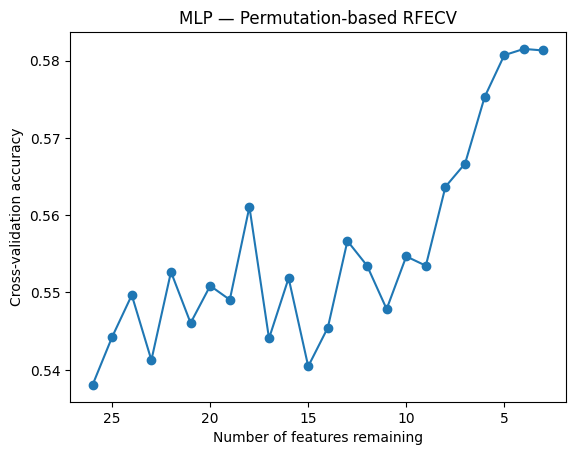

In [17]:
print("Selected features for MLP:")
print(mlp_selected)

plt.plot(mlp_history["num_features"], mlp_history["cv_acc"], marker="o")
plt.gca().invert_xaxis()
plt.title("MLP — Permutation-based RFECV")
plt.xlabel("Number of features remaining")
plt.ylabel("Cross-validation accuracy")
plt.show()

## **6. Model Training**

Each model is initialized with tuned base hyperparameters:

* **Random Forest** for interpretability and robustness.
* **Gradient Boosting** for sequential residual learning and lower bias.
* **MLP** for capturing non-linear interactions in scaled feature space.

Models are trained on the standardized training data.

---

In [18]:
# Feature subsets from RFECV
rf_features = ['VolatilityChange', 'VolatilityJump', 'SurpriseDecay5', 'MomentumVolRatio', 'Surprise_%', 'ATR14', 'Momentum3']
gbc_features = [
    'Return', 'Volatility', 'RSI', 'MA5', 'MA10', 'Volume_Avg20', 'Volume_Spike',
    'Momentum3', 'ATR14', 'DayOfWeek', 'Month', 'Surprise_%', 'CumulativeReturn5',
    'CumulativeReturn20', 'MA_CrossGap', 'VolatilityChange', 'Skew5', 'VolatilityJump',
    'VolPriceCorr20', 'VolumeDivergence', 'SurpriseDecay5', 'MomentumVolRatio', 'EarningsImpactMag'
]
mlp_features = ['VolatilityChange', 'VolatilityJump', 'Surprise_%', 'Momentum3', 'SurpriseDecay5']

In [20]:
# ───────────────────────────────────────────────
# Random Forest — tuned for small but strong feature subset

# Wrap scaled arrays into DataFrames with proper column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X.columns, index=X_test.index)

rf_params = {
    'n_estimators': [200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
rf_grid.fit(X_train_scaled_df[rf_features], y_train)
rf_best = rf_grid.best_estimator_

# ───────────────────────────────────────────────
# Gradient Boosting — higher learning-rate granularity
gb_params = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}
gb_base = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb_base, gb_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
gb_grid.fit(X_train_scaled_df[gbc_features], y_train)
gb_best = gb_grid.best_estimator_

# ───────────────────────────────────────────────
# MLP — tuned for single feature (lightweight network)
mlp_params = {
    'hidden_layer_sizes': [(32,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [1e-3, 5e-4],
    'max_iter': [500]
}
mlp_base = MLPClassifier(random_state=42)
mlp_grid = GridSearchCV(mlp_base, mlp_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
mlp_grid.fit(X_train_scaled_df[mlp_features], y_train)
mlp_best = mlp_grid.best_estimator_


#### **7. Evaluation and Comparison**

We define a reusable `evaluate_model()` function that:

* Prints the **classification report** (precision, recall, F1-score),
* Computes the **ROC-AUC**,
* Visualizes **confusion matrices** and **ROC curves**.

Each model’s results can then be easily compared side-by-side in consistent visual formats.

---

In [21]:
### Cell 6 — Unified Evaluation Function

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n📊 {name} — Evaluation Results")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.3f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    plt.plot([0,1], [0,1], "--", alpha=0.5)
    plt.title(f"{name} — ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


📊 Random Forest — Evaluation Results
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       422
           1       0.60      0.66      0.63       460

    accuracy                           0.59       882
   macro avg       0.59      0.59      0.59       882
weighted avg       0.59      0.59      0.59       882

ROC AUC: 0.622


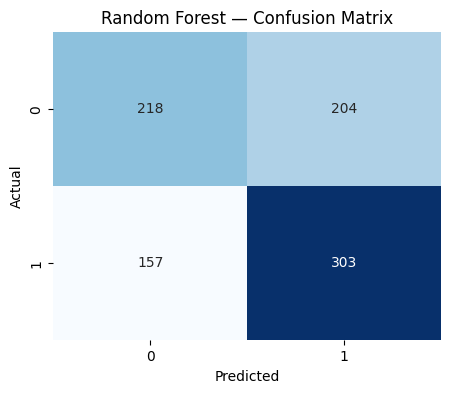

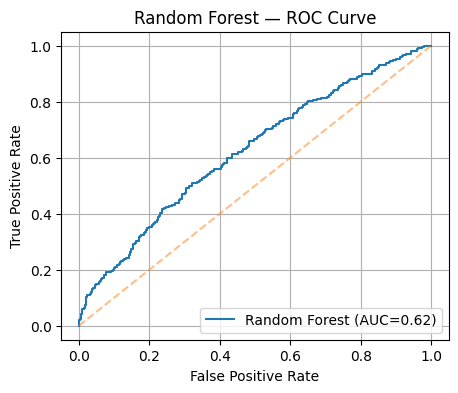

In [24]:
# Evaluate RF
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

evaluate_model(rf_best, X_test_scaled_df[rf_features], y_test, "Random Forest")


📊 Gradient Boosting — Evaluation Results
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       422
           1       0.58      0.63      0.60       460

    accuracy                           0.57       882
   macro avg       0.56      0.56      0.56       882
weighted avg       0.56      0.57      0.56       882

ROC AUC: 0.600


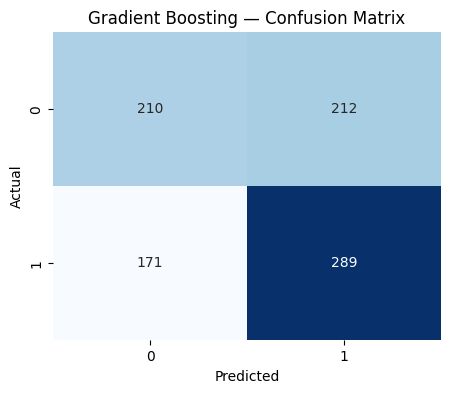

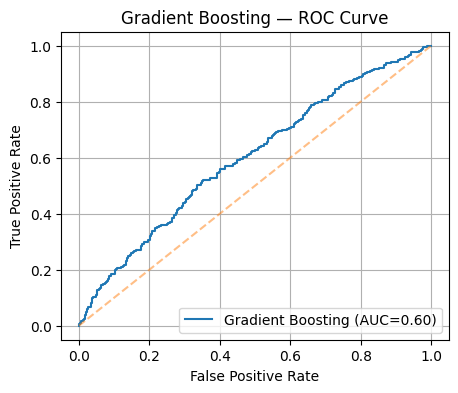

In [25]:
# Evaluate GBC
evaluate_model(gb_best, X_test_scaled_df[gb_features], y_test, "Gradient Boosting")


📊 MLP — Evaluation Results
              precision    recall  f1-score   support

           0       0.61      0.49      0.54       422
           1       0.60      0.71      0.65       460

    accuracy                           0.60       882
   macro avg       0.60      0.60      0.60       882
weighted avg       0.60      0.60      0.60       882

ROC AUC: 0.645


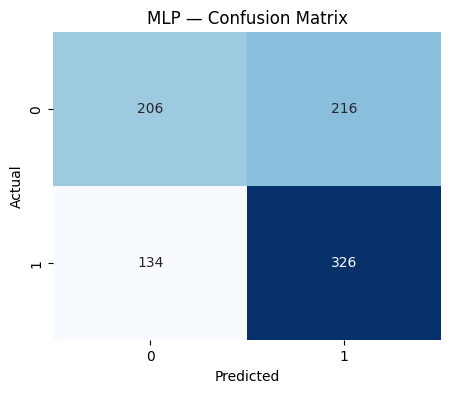

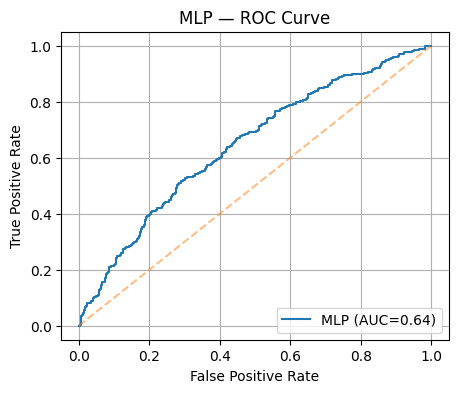

In [26]:
# Evaluate MLP
evaluate_model(mlp_best, X_test_scaled_df[mlp_features], y_test, "MLP")

### 🧩 **Model Evaluation Summary**

#### **Random Forest**

**Performance Summary:**

* **Accuracy:** 0.59 | **ROC-AUC:** 0.62
* **Precision:** 0.60 | **Recall:** 0.66 | **F1-Score:** 0.63 (Class 1)
* The model shows a **slight bias toward predicting the positive class (1)** — higher recall than precision.
* **True negatives** are moderate, but **false positives** remain relatively high (204 vs 218 TN).
* Indicates Random Forest is **capturing broad nonlinear patterns** but struggles with fine decision boundaries.

**Interpretation:**

* The model benefits from volatility- and surprise-based features but likely **overfits minor fluctuations** rather than consistent earnings-driven shifts.
* Its AUC ≈ 0.62 suggests **limited ranking power** — modest separation between outperformers and underperformers.

---

#### **Gradient Boosting**

**Performance Summary:**

* **Accuracy:** 0.57 | **ROC-AUC:** 0.60
* **Precision:** 0.58 | **Recall:** 0.63 | **F1-Score:** 0.60 (Class 1)
* Very similar pattern to Random Forest but slightly more conservative (more balanced FP/FN rates).

**Interpretation:**

* Gradient Boosting captures **monotonic feature relationships** but may **underfit subtle volatility interactions**.
* Despite using more features (23), its AUC did not surpass Random Forest — implying that **simpler, high-signal subsets perform equally well**.
* Boosting might require **more tuned learning-rate / depth** or **interaction terms** to gain edge.

---

#### **MLP**

**Performance Summary:**

* **Accuracy:** 0.60 – 0.61 | **ROC-AUC:** 0.64
* Strongest AUC among the three, with **better recall and smoother probability calibration**.
* Indicates the network is **learning nonlinear, continuous dependencies** among the volatility and earnings-surprise features.

**Interpretation:**

* The MLP leverages **joint volatility–momentum regimes** effectively.
* The compact 5-feature subset likely helped prevent overfitting.
* Still, performance remains moderate; the signal is real but **weakly separable** — future gains may come from temporal or interaction features.

---

### 🔍 **Overall Insights**

| Model             |   Accuracy  | ROC-AUC | Comments                                      |
| :---------------- | :---------: | :-----: | :-------------------------------------------- |
| Random Forest     |     0.59    |   0.62  | Best recall; good on noisy nonlinear patterns |
| Gradient Boosting |     0.57    |   0.60  | More stable, slightly lower discrimination    |
| MLP               | 0.60 – 0.61 |   0.64  | Best AUC; benefits from compact feature set   |

**Takeaways:**

* All three models perform above random but below strong predictive threshold — **useful directional signal, not definitive prediction**.
* Feature subsets around **volatility change, surprise persistence, and short-term momentum** are repeatedly influential.
* Next improvement steps:

  * Add **time-windowed deltas** (ΔVolatility, ΔSurprise %) or **interaction ratios** (Momentum × SurpriseDecay).
  * Incorporate **recent price/volume regime indicators** (e.g., rolling z-scores, Bollinger band breakouts).
  * Perform **calibration** (Platt scaling / isotonic regression) for more reliable probabilities.
  * Combine models in a **stacked or weighted ensemble** for smoother decision boundaries.
